# Introduction

This notebook demonstrates some basic data handling using the Pandas package and the application of linear methods to identify relationships in materials data. We will be creating a rudimentary prediction model for the bulk modulus of an element from various basic elemental properties. For the purposes of this exercise, we will assume that a linear relationship does indeed exist.

In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
mpl.rcParams.update(params)

%matplotlib inline

## Load in the elemental dataset using pandas' read_csv method. This data was obtained from the Materials Project for the ground state structure of each element only.
The columns are:
- K: Bulk modulus in GPa
- MP: Melting point in K
- BP: Boiling point in K
- Z: Atomic number
- X: Pauling electronegativity
- r: Atomic radius in angstroms

In [12]:
data = pd.read_csv("element_data.csv", index_col=0)
print(data)

             K       MP      BP   Z     X     r
Element                                        
Ac        29.0  1323.00  3573.0  89  1.10  1.95
Ag        88.0  1234.93  2435.0  47  1.93  1.60
Al        83.0   933.47  2792.0  13  1.61  1.25
As        40.0  1090.00   887.0  33  2.18  1.15
Au       137.0  1337.33  3129.0  79  2.54  1.35
...        ...      ...     ...  ..   ...   ...
W        304.0  3695.00  5828.0  74  2.36  1.35
Y         41.0  1799.00  3609.0  39  1.22  1.80
Yb        15.0  1097.00  1469.0  70  1.10  1.75
Zn        67.0   692.68  1180.0  30  1.65  1.35
Zr        94.0  2128.00  4682.0  40  1.33  1.55

[83 rows x 6 columns]


Since a strict linear relationship may not exist between K and the other variables, we will create a few additional features based on simple transformations of the inputs.

In [13]:
data["X^2"] = data["X"] ** 2
data["sqrt(X)"] = data["X"] ** 0.5
data["r^2"] = data["r"] ** 2
data["sqrt(r)"] = data["r"] ** 0.5
print(data)

             K       MP      BP   Z     X     r     X^2   sqrt(X)     r^2  \
Element                                                                     
Ac        29.0  1323.00  3573.0  89  1.10  1.95  1.2100  1.048809  3.8025   
Ag        88.0  1234.93  2435.0  47  1.93  1.60  3.7249  1.389244  2.5600   
Al        83.0   933.47  2792.0  13  1.61  1.25  2.5921  1.268858  1.5625   
As        40.0  1090.00   887.0  33  2.18  1.15  4.7524  1.476482  1.3225   
Au       137.0  1337.33  3129.0  79  2.54  1.35  6.4516  1.593738  1.8225   
...        ...      ...     ...  ..   ...   ...     ...       ...     ...   
W        304.0  3695.00  5828.0  74  2.36  1.35  5.5696  1.536229  1.8225   
Y         41.0  1799.00  3609.0  39  1.22  1.80  1.4884  1.104536  3.2400   
Yb        15.0  1097.00  1469.0  70  1.10  1.75  1.2100  1.048809  3.0625   
Zn        67.0   692.68  1180.0  30  1.65  1.35  2.7225  1.284523  1.8225   
Zr        94.0  2128.00  4682.0  40  1.33  1.55  1.7689  1.153256  2.4025   

For ease of interpretation, let's define our X and y.

In [14]:
features = [c for c in data.columns if c != "K"]
x = data[features]
y = data["K"]

We will now perform a standard multiple linear regression using scikit-learn.

K = -243.8 + 4.25e-02 MP + 2.76e-02 BP + -2.48e-01 Z + 3.92e+02 X + -3.55e+02 r + -4.96e+01 X^2 + -3.85e+02 sqrt(X) + 5.40e+01 r^2 + 5.00e+02 sqrt(r)


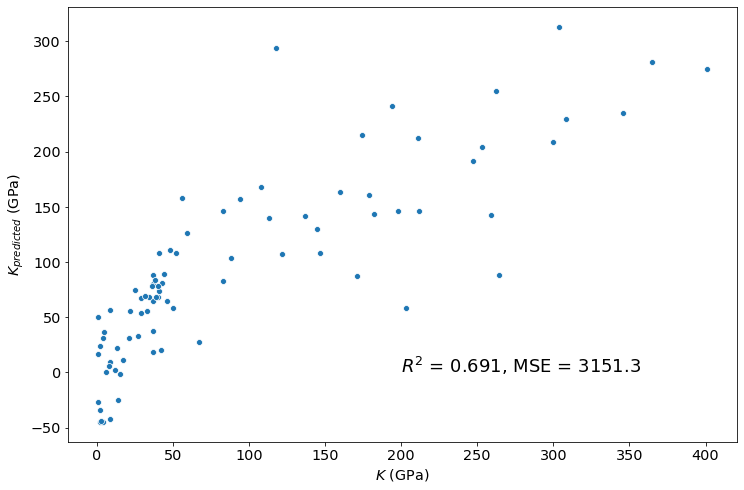

In [19]:
reg = linear_model.LinearRegression()
reg.fit(x, y)
r2 = reg.score(x, y)
equation = ["%.2e %s" % (v, f) for v, f in zip(reg.coef_, features)]
print("K = %.1f + %s" % (reg.intercept_, " + ".join(equation)))
f, ax = plt.subplots(figsize=(12, 8))
yhat = reg.predict(data[features])
sns.scatterplot(y, yhat)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
l = plt.annotate("$R^2$ = %.3f, MSE = %.1f" % (r2, mean_squared_error(y, yhat)), (200, 0), fontsize=18)

# Correlations between features

Here, we will look at correlations between features. First, we do a pair plot between features.

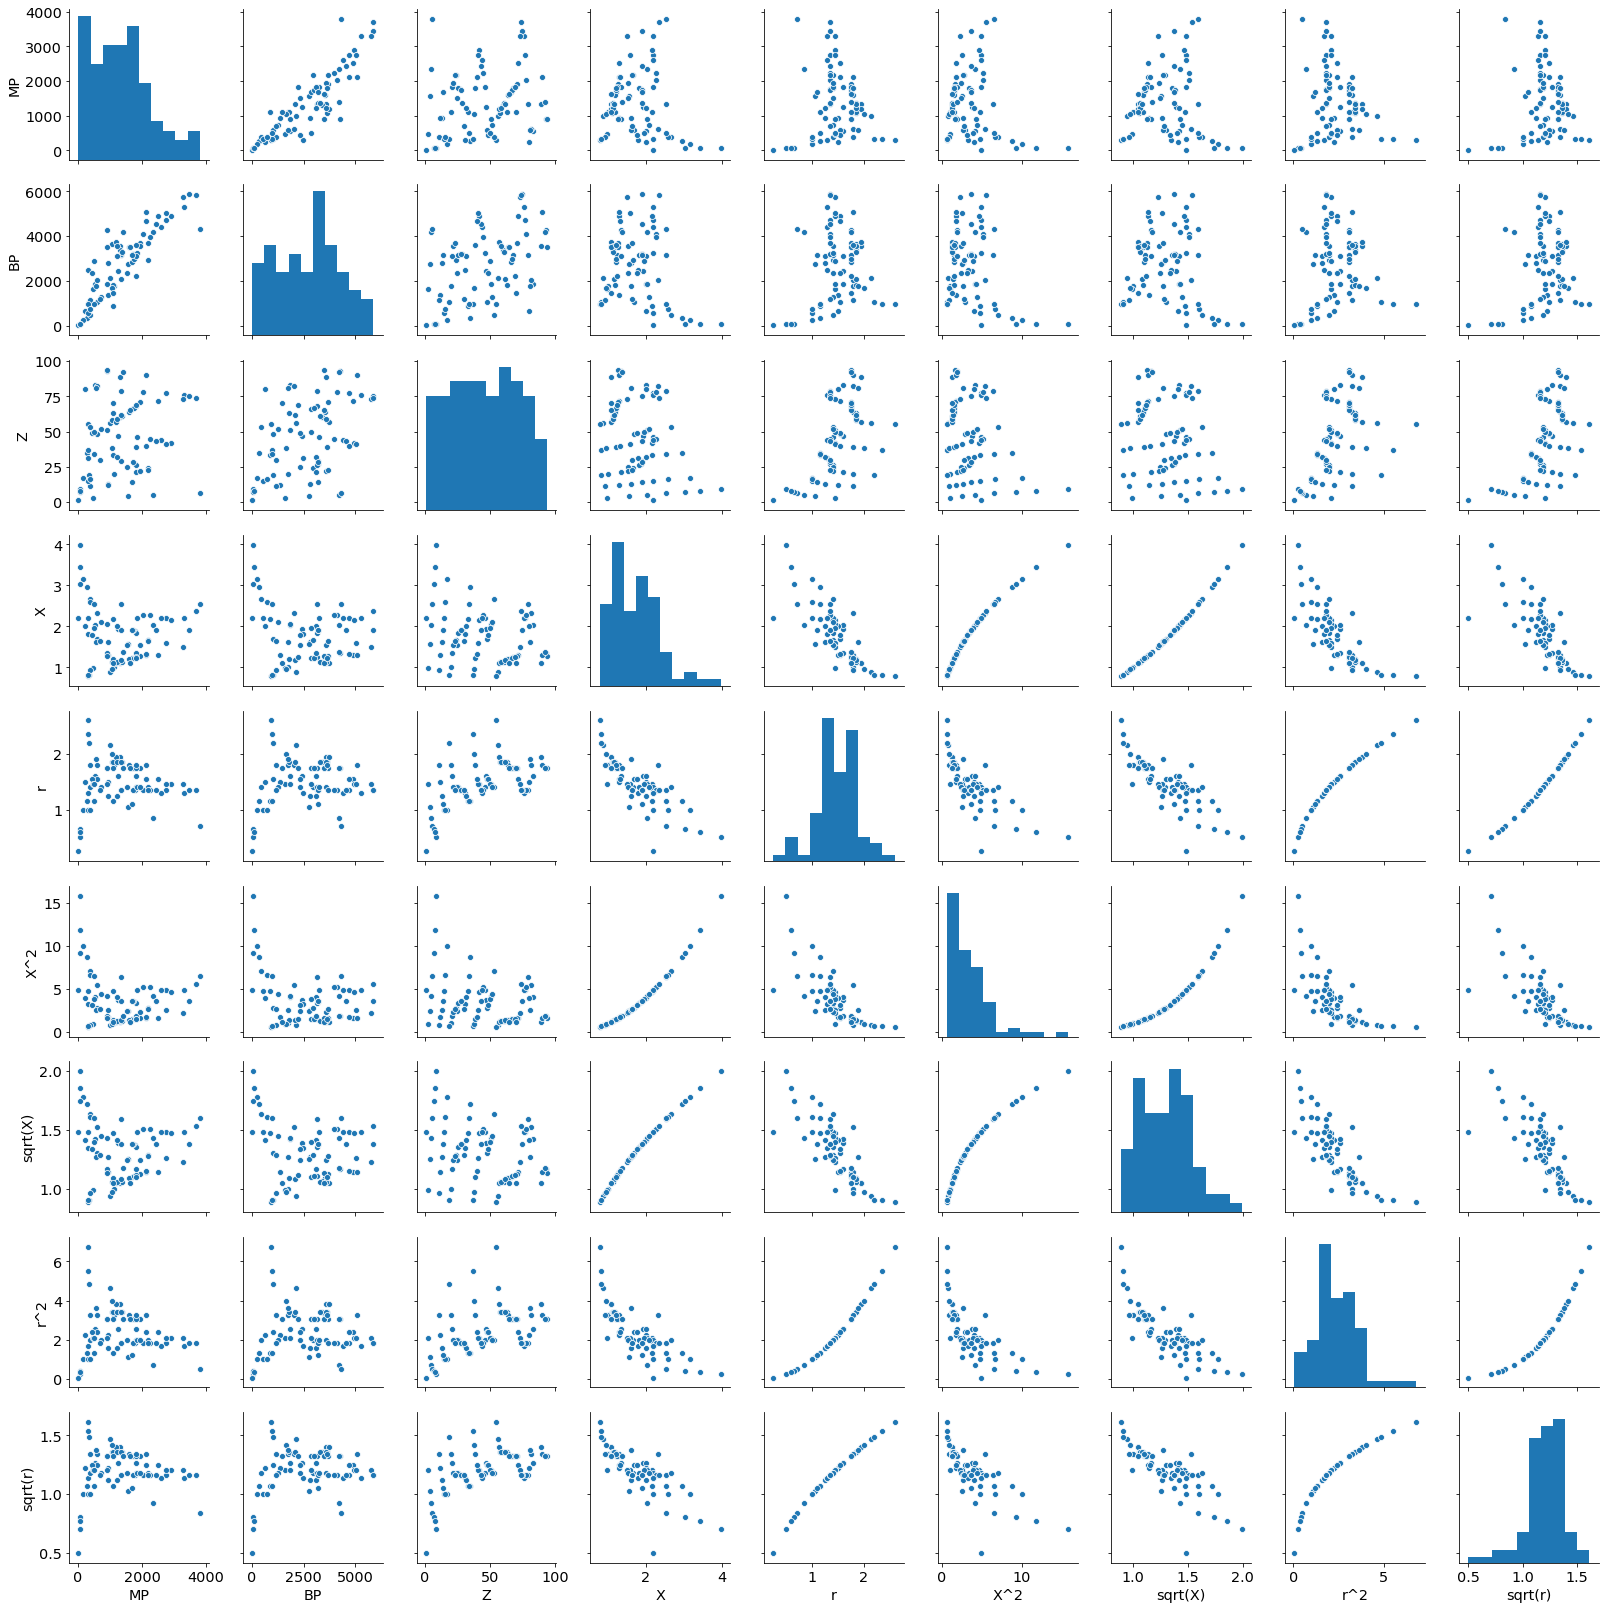

In [6]:
grid = sns.pairplot(data[features])

From the plot, it is clear that MP and BP are correlated with each other. And X is inversely related to r in some way. Obviously, X and $X^2$ are correlated. Another way to plot this is using a correlation plot.

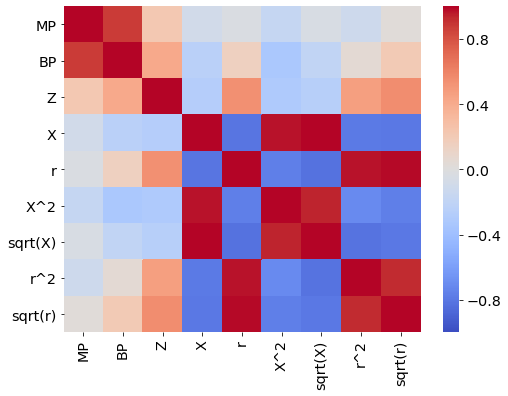

In [7]:
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(x.corr(), cmap="coolwarm", vmin=-1, vmax=1, ax=ax)

# Subset selection

# Shrinkage

Here, we will use shrinkage methods to shrink the features.

In [49]:
scaler = StandardScaler()
scaler.fit(x)
means_ = scaler.mean_
stds_ = scaler.scale_
z = scaler.transform(x)

In [61]:
from sklearn.model_selection import cross_validate, KFold

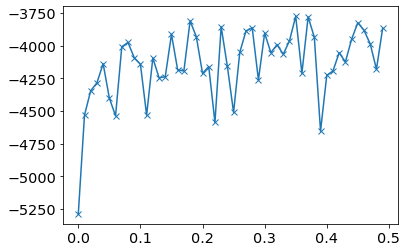

In [89]:
results = []
coeffs = []
kfold = KFold(n_splits=10, shuffle=True)
for alpha in np.arange(0, 0.5, 0.01):
    ridge = linear_model.Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(z, y)
    coeffs.append(ridge.coef_)
    scores = cross_validate(ridge, z, y, cv=kfold, scoring="neg_mean_squared_error")
    # print(scores)
    results.append((alpha, np.mean(scores["test_score"])))

results = pd.DataFrame(results, columns=["alpha", "score"])
plt.plot(results["alpha"], results["score"], '-x')
# plt.plot(results["alpha"], coeffs)
# r2 = reg.score(z, y)
# equation = ["%.2e %s" % (v, f) for v, f in zip(reg.coef_, features)]
# print("K = %.1f + %s" % (reg.intercept_, " + ".join(equation)))
# f, ax = plt.subplots(figsize=(12, 8))
# yhat = reg.predict(z)
# sns.scatterplot(y, yhat)
# l = plt.ylabel("$K_{predicted}$ (GPa)")
# l = plt.xlabel("$K$ (GPa)")
# l = plt.annotate("$R^2$ = %.3f, MSE = %.1f" % (r2, mean_squared_error(y, yhat)), (200, 0), fontsize=18)

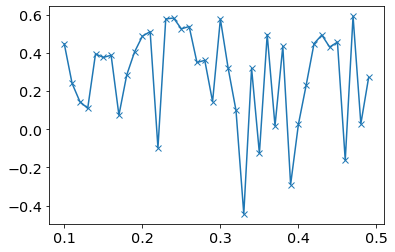

In [99]:
results = []
coeffs = []
for alpha in np.arange(0.1, 0.5, 0.01):
    lasso = linear_model.Lasso(alpha=alpha, max_iter=1000000)
    lasso.fit(z, y)
    coeffs.append(lasso.coef_)
    lasso = linear_model.Lasso(alpha=alpha, max_iter=100000)
    scores = cross_validate(lasso, z, y, cv=kfold)
    # print(scores)
    results.append((alpha, np.mean(scores["test_score"])))

results = pd.DataFrame(results, columns=["alpha", "score"])
plt.plot(results["alpha"], results["score"], '-x')